# Extract annotation information from OMIM
## OMIM® - Online Mendelian Inheritance in Man®

To utilize this notebook: 

1. Go to [OMIM database](https://go.drugbank.com/releases/latest) and submit a reuest to download files.
2. Follow the instructions to obtain download access for MIM files.
3. After receiving access (check email), download the following files:
    * `mim2gene.txt`: A tab-delimited file linking MIM numbers with NCBI Gene IDs, Ensembl Gene IDs, and HGNC Approved Gene Symbols.
    * `mimTitles.txt`A tab-delimited file of MIM numbers and titles.
    * `genemap2.txt`A tab-delimited file containing OMIM's Synopsis of the Human Gene Map including additional information such as genomic coordinates and inheritance.
    * `morbidmap.txt`A tab-delimited file of OMIM's Synopsis of the Human Gene Map (same as `genemap2.txt` above) sorted alphabetically by disorder.
4. Remember clear out any personal account information and ensure the downloaded OMIM file(s) remains local!

### Import packages

In [1]:
from datetime import datetime
from warnings import warn
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    INTERIM_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    read_rbc_model,
    get_annotation_df,
    visualize_comparison,
    compare_tables,
    show_versions
)
from rbc_gem_utils.util import build_string
MIM_PATH = "/MIM"

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


## Check OMIM version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 
### Last update: January 10th, 2024
* Major updates appear to be monthly. See last update [here](https://omim.org/statistics/update).
* Data files are updated nightly.

In [2]:
last_updated = {}
for mim_filename in [
    "mim2gene.txt",
    "genemap2.txt",
    "morbidmap.txt",
    "mimTitles.txt",
]:
    with open(f"{ROOT_PATH}{DATABASE_PATH}{MIM_PATH}/{mim_filename}") as file:
        for line in file:
            if line.startswith("# Generated"):
                break
        date = line.split(" ")[-1]
        date = date.strip()
        date = datetime.strptime(date, "%Y-%m-%d").strftime("%Y-%m-%d")
        last_updated[mim_filename] = date
last_updated = set(last_updated.values())
assert len(last_updated) == 1, "Files were not all downloaded at the same time"
last_updated = list(last_updated).pop()
print(f"Files last generated on: {last_updated}")

Files last generated on: 2024-01-11


In [3]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
print_footer_notes = False
overwrite = True
compare = True
database_tag = "MIM"
use_date_tag = True


## Load RBC-GEM model
### Current Version: 0.3.0

In [4]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,14dc0bb90
Number of metabolites,292
Number of reactions,348
Number of genes,283
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [5]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), 
    ["uniprot", "ncbigene", "hgnc.symbol", "ensembl", "mim"]
).rename({"id": annotation_type}, axis=1)

for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].str.split(";")
    df_model_mappings = df_model_mappings.explode(col)
print(df_model_mappings.nunique(dropna=True))
df_model_mappings

genes          283
uniprot        283
ncbigene       281
hgnc.symbol    283
ensembl        277
mim            467
dtype: int64


,genes,uniprot,ncbigene,hgnc.symbol,ensembl,mim
0,NMRK1,Q9NWW6,54981,NMRK1,ENSG00000106733,608704
1,RPE,Q96AT9,6120,RPE,ENSG00000197713,180480
2,RPIA,P49247,22934,RPIA,ENSG00000153574,180430
2,RPIA,P49247,22934,RPIA,ENSG00000153574,608611
3,COMTD1,Q86VU5,118881,COMTD1,NaN,NaN
...,...,...,...,...,...,...
280,ATP1B2,P14415,482,ATP1B2,ENSG00000129244,182331
281,ATP1B4,Q9UN42,23439,ATP1B4,ENSG00000101892,301073
282,ATP1A1,P05023,476,ATP1A1,ENSG00000163399,182310
282,ATP1A1,P05023,476,ATP1A1,ENSG00000163399,618036


In [6]:
annotation_key = "mim"

query_ids = df_model_mappings[annotation_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[annotation_key].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings = df_model_mappings[[annotation_type, annotation_key]].drop_duplicates()
df_model_mappings

Number of model genes associated with query: 283
Number of unique IDs to query: 467


,genes,mim
0,NMRK1,608704
1,RPE,180480
2,RPIA,180430
2,RPIA,608611
3,COMTD1,NaN
...,...,...
280,ATP1B2,182331
281,ATP1B4,301073
282,ATP1A1,182310
282,ATP1A1,618036


## Load MIM data
### MIM Number mapping 

In [7]:
df_mim = pd.read_csv(f"{database_dirpath}{MIM_PATH}/mim2gene.txt", sep="\t", header=4, dtype=str)
df_mim = df_mim.rename({
    "# MIM Number": "mim",
    "Entrez Gene ID (NCBI)": "ncbigene",
    "Approved Gene Symbol (HGNC)": "hgnc.symbol",
    "Ensembl Gene ID (Ensembl)": "ensembl",
    "MIM Entry Type (see FAQ 1.3 at https://omim.org/help/faq)": "MIM Entry Type",
}, axis=1)
df_model_mim = df_mim[df_mim[annotation_key].isin(query_ids)]
df_removed = df_model_mim[df_model_mim["MIM Entry Type"] == "moved/removed"]
df_model_mim = df_model_mim[df_model_mim["MIM Entry Type"] != "moved/removed"].reset_index(drop=True)
df_model_mim = df_model_mim.replace("", float("nan"))
df_model_mim

,mim,MIM Entry Type,ncbigene,hgnc.symbol,ensembl
0,100640,gene,216,ALDH1A1,ENSG00000165092
1,100660,gene,218,ALDH3A1,ENSG00000108602
2,102600,gene,353,APRT,ENSG00000198931
3,102700,phenotype,NaN,NaN,NaN
4,102750,gene,132,ADK,ENSG00000156110
...,...,...,...,...,...
461,619864,phenotype,NaN,NaN,NaN
462,619910,phenotype,NaN,NaN,NaN
463,620023,phenotype,NaN,NaN,NaN
464,620025,phenotype,NaN,NaN,NaN


### MIM Gene mapping 

In [8]:
df_genemap = pd.read_csv(f"{database_dirpath}{MIM_PATH}/genemap2.txt", sep="\t", header=3, dtype=str)

# Get footer comments
df_footer_comments = df_genemap[df_genemap["MIM Number"].isna()]
df_footer_comments = df_footer_comments["# Chromosome"].replace("#", "")
df_footer_comments = df_footer_comments[4:].reset_index(drop=True)
if print_footer_notes:
    for value in df_footer_comments.values:
        print(value)

df_genemap = df_genemap[~df_genemap["MIM Number"].isna()]
df_genemap = df_genemap.replace("", float("nan"))
df_genemap.head()

,# Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Approved Gene Symbol,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID
0,chr1,1,27600000,1p36,NaN,607413,AD7CNTP,Alzheimer disease neuronal thread protein,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,1,27600000,1p36,NaN,612367,ALPQTL2,"Alkaline phosphatase, plasma level of, QTL 2",NaN,100196914,NaN,linkage with rs1780324,"{Alkaline phosphatase, plasma level of, QTL 2}...",NaN
2,chr1,1,123400001,1p,NaN,606788,ANON1,"Anorexia nervosa, susceptibility to, 1",NaN,171514,NaN,NaN,"{Anorexia nervosa, susceptibility to, 1}, 6067...",NaN
3,chr1,1,27600000,1p36,NaN,605462,BCC1,"Basal cell carcinoma, susceptibility to, 1",NaN,100307118,NaN,associated with rs7538876,"{Basal cell carcinoma, susceptibility to, 1}, ...",NaN
4,chr1,1,27600000,1p36,NaN,606928,BMND3,Bone mineral density QTL 3,NaN,246259,NaN,?another locus at 3p21,"[Bone mineral density QTL 3], 606928 (2)",NaN


### MIM Morbid mapping 

In [9]:
df_morbidmap = pd.read_csv(f"{database_dirpath}{MIM_PATH}/morbidmap.txt", sep="\t", header=3, dtype=str)

# Get footer comments
df_footer_comments = df_morbidmap[df_morbidmap["MIM Number"].isna()]
df_footer_comments = df_footer_comments["# Phenotype"].replace("#", "")
df_footer_comments = df_footer_comments[4:].reset_index(drop=True)
if print_footer_notes:
    for value in df_footer_comments.values:
        print(value)
# Get morbid map data
df_morbidmap = df_morbidmap[~df_morbidmap["MIM Number"].isna()]
df_morbidmap = df_morbidmap.replace("", float("nan"))
df_morbidmap.head()

,# Phenotype,Gene/Locus And Other Related Symbols,MIM Number,Cyto Location
0,"17,20-lyase deficiency, isolated, 202110 (3)","CYP17A1, CYP17, P450C17",609300,10q24.32
1,"17-alpha-hydroxylase/17,20-lyase deficiency, 2...","CYP17A1, CYP17, P450C17",609300,10q24.32
2,"2,4-dienoyl-CoA reductase deficiency, 616034 (3)","NADK2, C5orf33, DECRD",615787,5p13.2
3,"2-methylbutyrylglycinuria, 610006 (3)","ACADSB, SBCAD",600301,10q26.13
4,"3-M syndrome 1, 273750 (3)","CUL7, 3M1",609577,6p21.1


### MIM Title mapping 

In [10]:
df_mimtitles = pd.read_csv(f"{database_dirpath}{MIM_PATH}/mimTitles.txt", sep="\t", header=2, dtype=str)
# Get footer comments
df_footer_comments = df_mimtitles[df_mimtitles["MIM Number"].isna()]
df_footer_comments = df_footer_comments["# Prefix"].replace("#", "")
df_footer_comments = df_footer_comments[4:].reset_index(drop=True)
if print_footer_notes:
    for value in df_footer_comments.values:
        print(value)

# Get morbid map data
df_mimtitles = df_mimtitles[~df_mimtitles["MIM Number"].isna()]
df_mimtitles = df_mimtitles.replace("", float("nan"))
df_mimtitles.head()

,# Prefix,MIM Number,Preferred Title; symbol,Alternative Title(s); symbol(s),Included Title(s); symbols
0,NaN,100050,"AARSKOG SYNDROME, AUTOSOMAL DOMINANT",NaN,NaN
1,Percent,100070,"AORTIC ANEURYSM, FAMILIAL ABDOMINAL, 1; AAA1","ANEURYSM, ABDOMINAL AORTIC; AAA;; ABDOMINAL AO...",NaN
2,Number Sign,100100,PRUNE BELLY SYNDROME; PBS,"ABDOMINAL MUSCLES, ABSENCE OF, WITH URINARY TR...",NaN
3,NaN,100200,ABDUCENS PALSY,NaN,NaN
4,Number Sign,100300,ADAMS-OLIVER SYNDROME 1; AOS1,"AOS;; ABSENCE DEFECT OF LIMBS, SCALP, AND SKUL...","APLASIA CUTIS CONGENITA, CONGENITAL HEART DEFE..."


### Map to model

,genes,mim,ncbigene,hgnc.symbol,ensembl,mgi
0,ABCC4,605250,10257,ABCC4,ENSG00000125257,MGI:2443111
1,ABCG2,138900;603756;614490,9429,ABCG2,ENSG00000118777,MGI:1347061;MGI:1351624
2,ACP1,171500,52,ACP1,ENSG00000143727,MGI:87881
3,ACSL1,152425,2180,ACSL1,ENSG00000151726,MGI:102797
4,ADA,102700;608958,100,ADA,ENSG00000196839,MGI:87916
...,...,...,...,...,...,...
278,UMPS,258900;613891,7372,UMPS,ENSG00000114491,MGI:1298388
279,UROD,176100;613521,7389,UROD,ENSG00000126088,MGI:98916
280,UROS,263700;606938,7390,UROS,ENSG00000188690,MGI:98917
281,XYLB,604049,9942,XYLB,ENSG00000093217,MGI:2142985


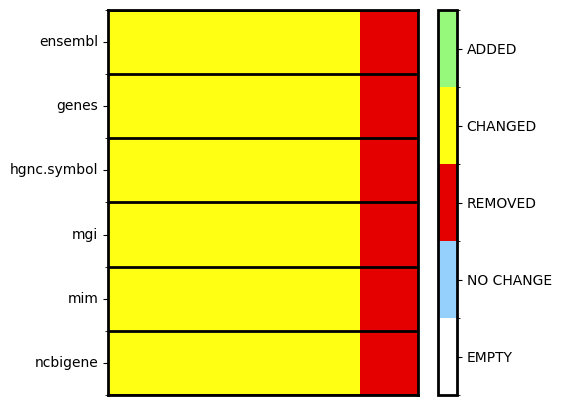

In [11]:
# Titles not necessary in  merge, captures duplicate information
df_model = df_model_mim.merge(
    df_genemap.loc[:, [
        '# Chromosome',
        'MIM Number',
        'Mouse Gene Symbol/ID',  
    ]],
    left_on="mim",
    right_on="MIM Number",
    how="left",
    suffixes=("", "_drop")
).drop(
    "MIM Number", 
    axis=1
).merge(
    df_morbidmap[['MIM Number', '# Phenotype', 'Cyto Location']],
    left_on="mim",
    right_on="MIM Number",
    how="left",
    suffixes=("", "_drop")
).drop(
    "MIM Number", 
    axis=1
)
# Seperate mouse genes IDs
# df_model["Mouse Gene Symbol"] = df_model["Mouse Gene Symbol/ID"].fillna("").apply(lambda x: x.split(" ")[0])
# df_model["Mouse Gene Symbol"] = df_model["Mouse Gene Symbol"].str.replace(",", ";")
df_model["Mouse Gene ID"] = df_model["Mouse Gene Symbol/ID"].fillna("").apply(lambda x: x.split(" ")[-1].lstrip("(").rstrip(")"))
df_model["Mouse Gene ID"] = df_model["Mouse Gene ID"].str.replace(",", ";")

df_model = df_model.rename({
    '# Chromosome': "chromosome",
    "# Phenotype": "phenotypes",
    "Mouse Gene ID": "mgi",
    "MIM Entry Type": "type",
}, axis=1)
df_model = df_model.loc[:, [
    "mim",
    "type",
    "ncbigene",
    "hgnc.symbol",
    "ensembl",
    "chromosome",
    "phenotypes",
    "mgi",
]]
df_model = pd.merge(
    df_model_mappings,
    df_model,
    left_on="mim",
    right_on="mim",
    how="left",
).replace("", float("nan"))
df_model = df_model.sort_values(["genes", "hgnc.symbol"])

df_annotations = df_model.loc[:, ["genes", "mim", "ncbigene", "hgnc.symbol", "ensembl", "mgi"]]
df_annotations = df_annotations.drop_duplicates().reset_index(drop=True)
df_annotations = df_annotations.groupby("genes").agg(lambda x: build_string(sorted(x.dropna())))
df_annotations = df_annotations.reset_index(drop=False).drop_duplicates()
if use_date_tag:
    date_tag = f"_{last_updated.replace('-', '_')}"
else:
    date_tag = ""

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", 
            sep="\t", 
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous,
        df_annotations,
    )
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_annotations.to_csv(f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", sep="\t")
    df_model.to_csv(f"{database_dirpath}/{database_tag}{date_tag}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{database_tag}.tsv", sep="\t")
    df_model.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{database_tag}{date_tag}.tsv", sep="\t")
df_annotations